# Stereo SLAM

This is a major part of this project and will likely take some time. 

For stereo, feel free to look up existing tutorials that implement this and write your own code here. Do not spend too long tweaking parameters here, focus on getting decent results and move on. You can also use OpenCV functions to backproject to 3D.

## PART 1: Stereo dense reconstruction

3-D point clouds are very useful in robotics for several tasks such as object detection, motion estimation (3D-3D matching or 3D-2D matching), SLAM, and other forms of scene understanding.  Stereo cameras provide  us  with  a  convenient  way  to  generate  dense  point  clouds. Dense here,  in  contrast  to sparse, means all the image points are used for the reconstruction.  In this part of the assignment you will be generating a dense 3D point cloud reconstruction of a scene from stereo images.

#### Procedure: 

<ol>
    <li> Generate a disparity map for each stereo pair.  Use OpenCV (e.g.  StereoSGBM) for this.  Notethat the images provided are already rectified and undistorted. </li>
    <li> Then, using the camera parameters and baseline information generate colored point clouds from each disparity map.  Some points will have invalid disparity values, so ignore them.  Use [Open3D]for storing your point clouds. </li>
    <li> Register (or transform) all the generated point clouds into your world frame by using the provided ground truth poses. </li>
    <li> Visualize the registered point cloud data, in color. Use Open3D for this. </li>
</ol>
    
    
Write briefly about how the disparity map is generated (if you used SGBM, write about SGBM).

In [1]:
import os
import time

import numpy as np 
import cv2 as cv
import tqdm.notebook as tqdm

import seaborn as sns
from matplotlib import pyplot as plt

import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
transformations = np.loadtxt("../data/poses.txt")

with open("../data/calib.txt", "r") as f:
    temp_data = f.readlines()
    calib_k = np.array(list(map(float, temp_data[1].strip().split()))).reshape(3, 3)
    calib_d = float(temp_data[4].split()[0])

In [3]:
os.makedirs("../results/", exist_ok=True)

for file_name in sorted(os.listdir("../data/img2"))[:2]:
    img_path_l = os.path.join("../data/img2", file_name)
    img_path_r = os.path.join("../data/img3", file_name)
    # Use OpenCV to generate disparity map
    img_l = cv.cvtColor(cv.imread(img_path_l), cv.COLOR_BGR2GRAY)
    img_r = cv.cvtColor(cv.imread(img_path_r), cv.COLOR_BGR2GRAY)
    win_size, min_disp = 3, 16
    stereo = cv.StereoSGBM_create(
        minDisparity = min_disp,
        numDisparities = 144 - min_disp,
        blockSize = 7,
        disp12MaxDiff = 1,
        speckleWindowSize = 400,
        speckleRange = 5,
        uniquenessRatio = 12,
        P1 = 8 * 3 * (win_size ** 2),
        P2 = 32 * 3 * (win_size ** 2),
    )
    disparity = stereo.compute(img_l, img_r).astype(np.float32) / 16.0 
    disparity += abs(disparity.min())
    # Create reverse projection matrix
    img = cv.imread(img_path_l)
    h, w = img.shape[0], img.shape[1]
    f = 7.070912e+02
    rev_proj_matrix = np.array([
        [1,  0,          0, -0.5*w],
        [0, -1,          0,  0.5*h], 
        [0,  0,          0,     -f], 
        [0,  0, -1/calib_d,      0]
    ])
    # 3D points from disparity map and reverse projection matrix
    points = cv.reprojectImageTo3D(disparity, rev_proj_matrix)
    colors = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # Remove the outlier points that have 0 depth
    mask = disparity > disparity.min()
    points = points[mask]
    colors = colors[mask]
    # Write the generated cloud to files
    with open(os.path.join("../results", file_name[: -4] + ".ply"), 'w') as f:
        f.write(f"""ply
            format ascii 1.0
            element vertex {len(points)}
            property float x
            property float y
            property float z
            property uchar red
            property uchar green
            property uchar blue
            end_header
        """)
        np.savetxt(
            f,
            np.hstack([
                points.reshape(-1,3), 
                colors.reshape(-1,3)
            ]),
            '%f %f %f %d %d %d'
        )

In [4]:
combined_pcd = o3d.geometry.PointCloud()
for idx, file in enumerate(sorted(os.listdir("../results/"))):
    pcd = o3d.io.read_point_cloud(os.path.join("../results/", file[:-4] + ".ply"))
    transformation_matrix = np.vstack((transformations[idx].reshape(3, 4), [0, 0, 0, 1]))
    transformation_matrix[:3, :3] = transformation_matrix[:3, :3].T
    pcd = pcd.transform(transformation_matrix)
    combined_pcd += pcd

o3d.visualization.draw_geometries([combined_pcd])

In [5]:
win = o3d.visualization.Visualizer()
win.create_window()
combined_pcd = o3d.geometry.PointCloud()
for idx, file in enumerate(sorted(os.listdir("../results/"))):
    pcd = o3d.io.read_point_cloud(os.path.join("../results/", file[:-4] + ".ply"))
    transformation_matrix = np.vstack((transformations[idx].reshape(3, 4), [0, 0, 0, 1]))
    transformation_matrix[:3, :3] = transformation_matrix[:3, :3].T
    pcd = pcd.transform(transformation_matrix)
    combined_pcd += pcd
    win.add_geometry(combined_pcd)
    win.poll_events()
    win.update_renderer()
    time.sleep(0.20)
    win.remove_geometry(combined_pcd)
win.poll_events()
win.destroy_window()

![image.png](../img/stereo_slam_image.png)

## PART 2: Motion estimation using iterative PnP

Using the generated reconstruction from the previous part, synthesize a new image taken by a virtualmonocular camera fixed at any arbitrary position and orientation.  Your task in this part is to recoverthis pose using an iterative Perspective-from-n-Points (PnP) algorithm. 

#### Procedure: 

<ol>
    <li> Obtain a set of 2D-3D correspondences between the the image and the point cloud.  Since hereyou’re generating the image, this should be easy to obtain. </li>
    <li> For this set of correspondences compute the total reprojection error c= $\sum_{i} ‖x_i−P_{k}X_i‖^2 $    where $P_{k}= K[R_{k}|t_{k}]$, $X_{i}$ is the 3D point in the world frame, $x_{i}$ is its corresponding projection. </li>
    <li> Solve for the pose $T_{k}$ that minimizes this non-linear reprojection error using a Gauss-Newton (GN)scheme.  Recall that in GN we start with some initial estimated value $x_{o}$ and iteratively refine the estimate using $x_{1}$= $∆x+x_0$, where $∆x$ is obtained by solving the normal equations $J^{T}J∆x$= -$J^{T}e$, until convergence.The main steps in this scheme are computing the corresponding Jacobians and updating the estimates correctly.  For our problem,  use a 12×1 vector parameterization for $T_{k}$(the top 3×4submatrix).  Run the optimization for different choices of initialization and report your observations. </li>
</ol>

Make sure that you write about how you calculate the residual and jacobians. Do not just include the code. The pose that you have been given is the ground truth, so using that will obviously give good results for optimization, so try out something else as well.

In [6]:
transform = transformations[np.random.randint(len(transformations))].reshape(3, 4)
r = transform[:, :3]
t = transform[:, 3:]
k = np.triu(np.random.random(size=(3, 3)))

p = k @ np.concatenate([r, t], axis=1)

pts_3d = np.asarray(combined_pcd.points)
pts_3d = np.concatenate([pts_3d, np.ones(shape=(len(combined_pcd.points), 1))], axis=1)
pts_2d = (p @ pts_3d.T).T
pts_2d = (pts_2d / pts_2d[:, 2:])[:, :2]

bot, top = np.min(pts_2d, axis=0), np.max(pts_2d, axis=0)

In [7]:
import jax
import jax.numpy as jnp

points_2d = jnp.array(pts_2d)
points_3d = jnp.array(pts_3d)

def residual(proj):
    proj = proj.reshape((3, 4))
    x = points_3d @ proj.T
    x = x / x[:, -1:]
    x = x[:, :-1]
    r = jnp.sum((points_2d - x) ** 2, axis=1)
    return r

INFO - 2021-11-30 23:27:28,469 - xla_bridge - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO - 2021-11-30 23:27:28,491 - xla_bridge - Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO - 2021-11-30 23:27:28,494 - xla_bridge - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
WARNING - 2021-11-30 23:27:28,497 - xla_bridge - No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [8]:
def gauss_newton(epochs=25):
    proj = np.random.random(3 * 4)
    history = {'loss': [np.sum(residual(proj))]}
    for i in range(epochs):
        j = jax.jacfwd(residual, argnums=0)(proj)
        r = residual(proj)
        delta = - np.linalg.pinv(j.T @ j) @ j.T @ r
        proj = proj + delta        
        history['loss'].append(np.sum(r))
    
    history['result'] = proj.reshape(3, 4)
    return history

In [9]:
history = gauss_newton()

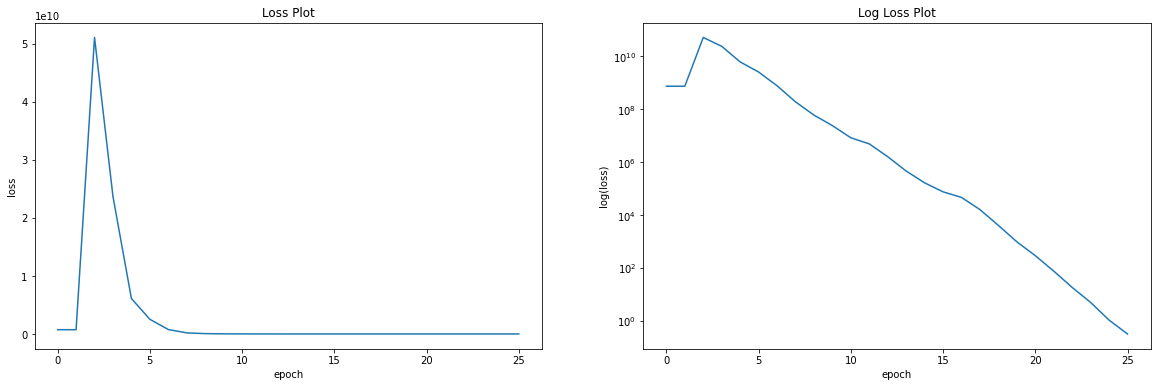

In [24]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Loss Plot')
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.ylabel('log(loss)')
plt.yscale('log')
plt.xlabel('epoch')
plt.title('Log Loss Plot')
plt.show()

In [11]:
print('Final Loss:', history['loss'][-1])

Final Loss: 0.3231235


## PART 3: Odometry Calculation

In part 1, you used the ground truth pose for registration. Here, try to estimate the pose using the RGB image data alone. 

#### Procedure:

1. This can be done by computing features across the two images and matching them. Since you already have the depth map, you now have correspondences between the depth maps of two images as well from the RGB feature matches. 
2. You can now convert this depth map to a point cloud.
3. Since you have correspondences between image points in the depth map, you have 3D correspondences here as well. Perform ICP here to get a good pose estimate.
4. Feed these initial pose estimates into the PnP pipeline and optimise further.

In [46]:
worlds = []
images = []

for file_name in sorted(os.listdir("../data/img2"))[:2]:
    img_path_l = os.path.join("../data/img2", file_name)
    img_path_r = os.path.join("../data/img3", file_name)
    # Use OpenCV to generate disparity map
    img_l = cv.cvtColor(cv.imread(img_path_l), cv.COLOR_BGR2GRAY)
    img_r = cv.cvtColor(cv.imread(img_path_r), cv.COLOR_BGR2GRAY)
    win_size, min_disp = 3, 16
    stereo = cv.StereoSGBM_create(
        minDisparity = min_disp,
        numDisparities = 144 - min_disp,
        blockSize = 7,
        disp12MaxDiff = 1,
        speckleWindowSize = 400,
        speckleRange = 5,
        uniquenessRatio = 12,
        P1 = 8 * 3 * (win_size ** 2),
        P2 = 32 * 3 * (win_size ** 2),
    )
    disparity = stereo.compute(img_l, img_r).astype(np.float32) / 16.0 
    disparity += abs(disparity.min())
    # Create reverse projection matrix
    img = cv.imread(img_path_l)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    h, w = img.shape[0], img.shape[1]
    f = 7.070912e+02
    rev_proj_matrix = np.array([
        [1,  0,          0, -0.5*w],
        [0, -1,          0,  0.5*h],
        [0,  0,          0,     -f],
        [0,  0, -1/calib_d,      0]
    ])
    # 3D points from disparity map and reverse projection matrix
    points = cv.reprojectImageTo3D(disparity, rev_proj_matrix)
    worlds.append(points)
    images.append(img)

worlds = np.stack(worlds)
images = np.stack(images)

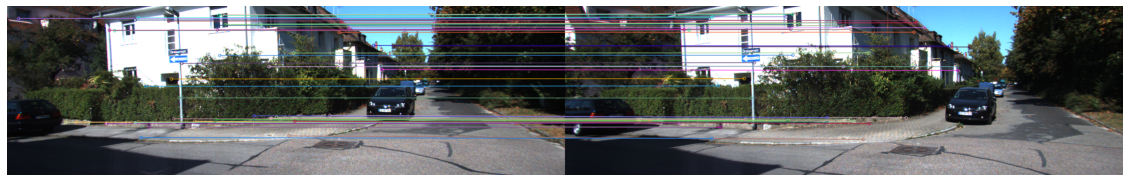

In [51]:
i = 0
j = 1

sift = cv.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(cv.cvtColor(images[i], cv.COLOR_BGR2GRAY), None)
keypoints_2, descriptors_2 = sift.detectAndCompute(cv.cvtColor(images[j], cv.COLOR_BGR2GRAY), None)

bf_matcher = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
matches = bf_matcher.match(descriptors_1, descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)
image_matching = cv.drawMatches(images[0], keypoints_1, images[1], keypoints_2, matches[:50], images[1], flags=2)

plt.figure(figsize=(20, 6))
plt.axis('off')
plt.imshow(image_matching)
plt.show()

In [66]:
for match in matches:
    u, v = match.queryIdx, match.trainIdx
    print(keypoints_1[u].pt, keypoints_2[v].pt)

(575.459228515625, 132.37184143066406) (610.90869140625, 131.9337158203125)
(619.39794921875, 283.9794006347656) (655.64990234375, 291.6087646484375)
(461.7288513183594, 51.8283805847168) (495.560791015625, 50.005828857421875)
(733.1077270507812, 36.717529296875) (771.0479125976562, 36.316009521484375)
(479.6865539550781, 40.11220169067383) (513.8432006835938, 37.875518798828125)
(451.38995361328125, 25.555469512939453) (485.378173828125, 22.972084045410156)
(288.04962158203125, 25.49102210998535) (323.4935607910156, 23.927480697631836)
(574.9302978515625, 44.7672004699707) (610.7269287109375, 42.7037467956543)
(599.3572387695312, 247.9550018310547) (634.8189086914062, 252.27427673339844)
(235.81553649902344, 53.492942810058594) (272.4393310546875, 51.982444763183594)
(360.75238037109375, 159.33877563476562) (393.1538391113281, 158.4904327392578)
(465.3581237792969, 19.872770309448242) (499.41107177734375, 17.480257034301758)
(458.4197998046875, 247.77789306640625) (490.5562438964844, 

(149.28221130371094, 236.55299377441406) (183.87576293945312, 234.4317626953125)
(861.848388671875, 172.29795837402344) (906.1203002929688, 175.55596923828125)
(853.929443359375, 216.71522521972656) (904.6739501953125, 221.90626525878906)
(918.0090942382812, 159.409912109375) (960.8943481445312, 162.98912048339844)
(933.8641967773438, 122.98609924316406) (978.67529296875, 125.93479919433594)
(223.72328186035156, 179.0227508544922) (256.0361022949219, 177.44183349609375)
(153.8381805419922, 179.2396240234375) (192.05673217773438, 177.2286834716797)
(1130.83251953125, 105.90123748779297) (1205.9532470703125, 107.42060089111328)
(402.5005798339844, 206.3797149658203) (433.5400390625, 207.40220642089844)
(483.57257080078125, 159.22450256347656) (516.490966796875, 159.3270263671875)
(723.257080078125, 300.12872314453125) (769.0147094726562, 311.6600646972656)
(666.2144165039062, 119.9565658569336) (706.1394653320312, 120.1878433227539)
(365.4632568359375, 8.537760734558105) (397.53073120117

In [48]:
images.shape

(2, 370, 1226, 3)